In [162]:
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
from vpython import *

In [163]:
%load_ext autoreload
%autoreload 2
import HEAD_RECON

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
head =HEAD_RECON.threeD_head.read_from_file(3,5)



In [165]:
#head.sparsify(0.3)
head.filter_nan()
head.filter_depth(1.5)
head.center()

In [166]:
head.create_vpython_spheres()
head.save()

In [167]:
plt.show()

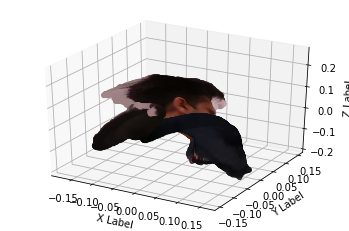

In [168]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(head.xyz[:,0], -head.xyz[:,2], -head.xyz[:,1], c=head.rgb)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


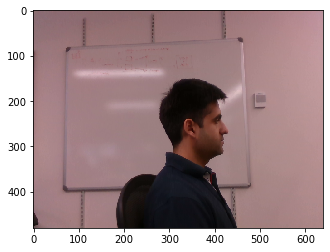

In [169]:
plt.imshow(head.twoD_image)

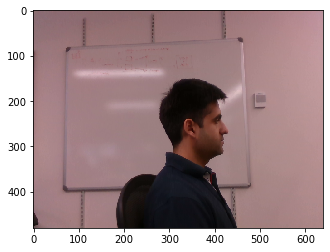

In [170]:
head.reset_filters()
im = head.get_filtered_image()
plt.imshow(im)

In [171]:
head.save()

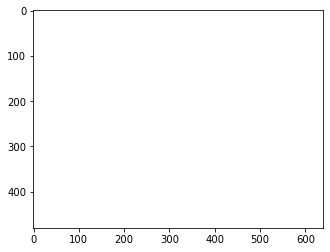

In [172]:
im = head.get_bw_image()
plt.imshow(im)

remove danlging start 53751
remove dangling end 53734
53734
remove danlging start 53734
remove dangling end 53730
53730
remove danlging start 53730
remove dangling end 53728
53728
remove danlging start 53728
remove dangling end 53727
53727
remove danlging start 53727
remove dangling end 53727
53727
53727
53510
53354
53213
53087
52968
52850
52730
52612
52496
52389
52289
52193
52100
52019
51949
51902
51864
51840
51820
51804
51790
51779
51770
51761
51752
51743
51735
51728
51721
51714
51707
51703
51700
51697
51694
51691
51689
51687
51685
51684
51684
remove danlging start 51684
remove dangling end 51680
51680
remove danlging start 51680
remove dangling end 51678
51678
remove danlging start 51678
remove dangling end 51677
51677
remove danlging start 51677
remove dangling end 51677
51677


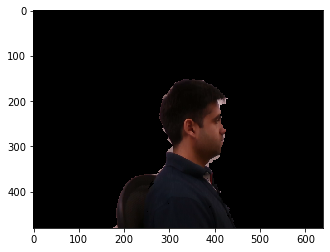

In [301]:
head.reset_filters()
head.filter_nan()
head.filter_depth(1.5)
head.remove_dangling()
head.remove_color()
head.remove_dangling()
head.center()
head.create_vpython_spheres()
head.save()
plt.imshow(head.get_filtered_image())
plt.show()


[0.553 0.436 0.446]
[0.16  0.114 0.115]
[0.637 0.505 0.516]
53751
53389
(53389, 3)
53087
(53087, 3)
52853
(52853, 3)
52648
(52648, 3)
52458
(52458, 3)
52296
(52296, 3)
52148
(52148, 3)
52008
(52008, 3)
51871
(51871, 3)
51745
(51745, 3)
51640
(51640, 3)
51560
(51560, 3)
51497
(51497, 3)
51455
(51455, 3)
51429
(51429, 3)
51412
(51412, 3)
51402
(51402, 3)
51393
(51393, 3)
51385
(51385, 3)
51378
(51378, 3)
51372
(51372, 3)
51366
(51366, 3)
51361
(51361, 3)
51356
(51356, 3)
51351
(51351, 3)
51345
(51345, 3)
51341
(51341, 3)
51339
(51339, 3)
51337
(51337, 3)
51336
(51336, 3)
51335
(51335, 3)
51334
(51334, 3)
51333
(51333, 3)
51333
(51333, 3)
remove danlging start 51333
remove dangling end 51318
51318
remove danlging start 51318
remove dangling end 51313
51313
remove danlging start 51313
remove dangling end 51310
51310
remove danlging start 51310
remove dangling end 51308
51308
remove danlging start 51308
remove dangling end 51307
51307
remove danlging start 51307
remove dangling end 51306
51

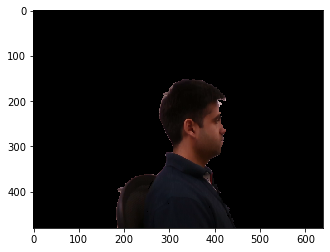

In [302]:
head.reset_filters()
head.filter_nan()
head.filter_depth(1.5)
head.remove_background_color()
head.remove_dangling()
plt.imshow(head.get_filtered_image())
plt.show()
head.center()
head.create_vpython_spheres()
head.save()

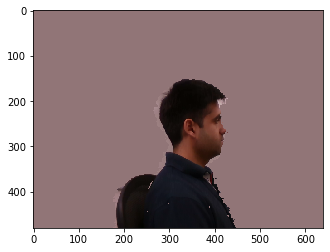

In [210]:
head.reset_filters()
head.filter_nan()
head.filter_depth(1.5)
plt.imshow(head.get_filtered_image())
plt.show()

In [280]:
theta = np.pi/6
R_x=np.asarray([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0,np.sin(theta),np.cos(theta)]])

R_y=np.asarray([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta),np,0,cos(theta)]])

R_z=np.asarray([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])

In [281]:
A= np.asarray([[1,0,0],[1,1,0],[1,1,1],[1,3,1]])
A.shape

(4, 3)

In [282]:
B=np.dot(A,R_z.T)
B.shape

(4, 3)

In [283]:
R_z.shape

(3, 3)

In [284]:
R,scale = orthogonal_procrustes(A, B, check_finite=True)

In [285]:
R

array([[ 8.66025404e-01,  5.00000000e-01,  9.27981198e-16],
       [-5.00000000e-01,  8.66025404e-01, -3.75257829e-16],
       [-1.10338080e-15, -1.31297421e-17,  1.00000000e+00]])

In [286]:
R_z.T

array([[ 0.8660254,  0.5      ,  0.       ],
       [-0.5      ,  0.8660254,  0.       ],
       [ 0.       ,  0.       ,  1.       ]])

In [291]:
np.dot(B,(np.linalg.inv(R)))

array([[ 1.00000000e+00,  4.51526294e-16, -9.27981198e-16],
       [ 1.00000000e+00,  1.00000000e+00, -5.52723369e-16],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  3.00000000e+00,  1.00000000e+00]])

In [294]:
import numpy as np
import numpy.linalg

# Relevant links:
#   - http://stackoverflow.com/a/32244818/263061 (solution with scale)
#   - "Least-Squares Rigid Motion Using SVD" (no scale but easy proofs and explains how weights could be added)


# Rigidly (+scale) aligns two point clouds with know point-to-point correspondences
# with least-squares error.
# Returns (scale factor c, rotation matrix R, translation vector t) such that
#   Q = P*cR + t
# if they align perfectly, or such that
#   SUM over point i ( | P_i*cR + t - Q_i |^2 )
# is minimised if they don't align perfectly.
def umeyama(P, Q):
    assert P.shape == Q.shape
    n, dim = P.shape

    centeredP = P - P.mean(axis=0)
    centeredQ = Q - Q.mean(axis=0)

    C = np.dot(np.transpose(centeredP), centeredQ) / n

    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    R = np.dot(V, W)

    varP = np.var(a1, axis=0).sum()
    c = 1/varP * np.sum(S) # scale factor

    t = Q.mean(axis=0) - P.mean(axis=0).dot(c*R)

    return c, R, t


# Testing

np.set_printoptions(precision=3)

a1 = np.array([
  [0, 0, -1],
  [0, 0, 0],
  [0, 0, 1],
  [0, 1, 0],
  [1, 0, 0],
])

a2 = np.array([
  [0, 0, 1],
  [0, 0, 0],
  [0, 0, -1],
  [0, 1, 0],
  [-1, 0, 0],
])
a2 *= 2 # for testing the scale calculation
a2 += 3 # for testing the translation calculation


c, R, t = umeyama(a1, a2)
print ("R =\n", R)
print ("c =", c)
print ("t =\n", t)
print
print ("Check:  a1*cR + t = a2  is", np.allclose(a1.dot(c*R) + t, a2))
err = ((a1.dot(c * R) + t - a2) ** 2).sum()
print ("Residual error", err)


R =
 [[-1.000e+00  2.119e-16  0.000e+00]
 [ 8.865e-17  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00 -1.000e+00]]
c = 1.9999999999999998
t =
 [3. 3. 3.]
Check:  a1*cR + t = a2  is True
Residual error 6.902532920683853e-31
